# Preface

As a NLP beginner, I would like to use this dataset to practice my skills. In this notebook, Logistic Regression is selected as a main model to proceed.

In below notebook, you can also find a practice to the same dataset done in Naive Bayes

https://www.kaggle.com/code/coronatianmao/nlp-beginner-bayes-disaster-tweets-dete#Data-preparation

*History scores:*

|  Version   | Score  | Comments  |
|  ----  | ----  | ----  |
| V25  | 0.74563 | Tuning the model with grid search by alpha, iteration |
| V19  | 0.74195 | Tuning the model with threshold |


# Loading needed packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import string
import nltk    
import matplotlib.pyplot as plt    
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn import feature_extraction, linear_model, model_selection, preprocessing

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load some useful functions below

Use below function to process tweet, it would return a list of words

In [2]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    tweet = re.sub(r'\$\w*', '', tweet)

    tweet = re.sub(r'^RT[\s]+', '', tweet)
  
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)


    tweet = re.sub(r'#', '', tweet)

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation

            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

Use below function to build the frequency matrix, in the form of ('word',1/0):number of words

In [3]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """

    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

# Explore datasets

In [4]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

Try to reduce imbalance issue in the training set

In [5]:
train_rm1 = train[train['target']==1].sample(3000, random_state=10)
train_rm0 = train[train['target']==0].sample(3000, random_state=10)
len(train_rm1)

train = pd.concat([train_rm1,train_rm0])

In [6]:
train_df1 = list(train[train['target']==1]['text'])
train_df0 = list(train[train['target']==0]['text'])
print(len(train_df1))
print(len(train_df0))

3000
3000


In [7]:
tweets = train_df1 + train_df0

# let's see how many tweets we have
print("Number of tweets: ", len(tweets))

labels = np.append(np.ones((len(train_df1))),np.zeros((len(train_df0))))

Number of tweets:  6000


In [8]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
#train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = test.append(train).drop_duplicates(keep=False)
print(len(test))

validation = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

1613


/tmp/ipykernel_737/2001340418.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(train).drop_duplicates(keep=False)


Download stop words list

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data preparation

In [10]:
# create frequency dictionary
freqs = build_freqs(tweets, labels)

# Model prepare - sigmoid, gradient descent

In [11]:
# Define sigmoid function
def sigmoid(z): 
    h = h = 1/(1+np.exp(z*(-1)))    
    return h

In [12]:
def gradientDescent(x, y, theta, alpha, num_iters):

    m = len(x)
    for i in range(0, num_iters):
        z = np.dot(x,theta)
        h = sigmoid(z)
        J = ((-1)/m)*(np.dot(np.transpose(y),np.log(h))+np.dot(np.transpose(1-y),np.log(1-h)))

        # update the weights theta
        theta = theta - ((alpha/m*(np.dot(np.transpose(x),(h-y)))))
        
    J = float(J)
    return J, theta

# Feature Extraction

In [13]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    word_l = process_tweet(tweet)
    x = np.zeros(3) 
    x[0] = 1 
    
    for word in word_l:

        x[1] += freqs.get((word,1),0)

        x[2] += freqs.get((word,0),0)
    
    x = x[None, :]
    assert(x.shape == (1, 3))
    return x

In [14]:
train_x = tweets
train_y = pd.DataFrame({'col':labels})

test_x = test['text']
test_y = test['target']

# Define Prediction Function

In [15]:
def predict_tweet(tweet, freqs, theta):

    x = extract_features(tweet, freqs)
    y_pred = sigmoid(np.dot(x,theta))

    return y_pred

Performance monitor

In [16]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet,thd=0.5):

    y_hat = []
    
    for tweet in test_x:
        y_pred = predict_tweet(tweet,freqs,theta)
        
        if y_pred > thd:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)


    accuracy = np.sum(np.array(y_hat)==np.squeeze(test_y))/len(np.array(y_hat))
    
    return accuracy

In [17]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

Y = train_y

#for itr in [11000,12000,13000,14000]:
#    for thd in [0.6,0.7,0.8]:
#        J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-08, itr)
        # print(f"The cost after training is {J:.8f}.")
        # print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")
#        tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta,predict_tweet,thd)
#        print(f"With iteration set as {itr}. threshold set as {thd}. The logistic regression model's accuracy = {tmp_accuracy:.4f}")

# EDA - Visualize the distribution of the training set

Visualize the training set with extracted frequence feature

In [18]:
rename_map_X = {0:'bias',1:'pos',2:'neg'}
rename_map_Y = {0:'target','col':'target'}

In [19]:
eda_X = pd.DataFrame(X).rename(columns=rename_map_X)
eda_Y = pd.DataFrame(Y).rename(columns=rename_map_Y)
eda_prep = pd.concat([eda_X,eda_Y],axis=1)

In [20]:
#temp = pd.DataFrame({'index':[7613],'bias':[1],'pos':[1],'neg':[2],'target':[0]})
#temp = temp.set_index('index')
#temp
#eda_prep = eda_prep[eda_prep['target']==1]
#eda_prep = pd.concat([eda_prep,temp]).sample(10)
#eda_prep

In [21]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

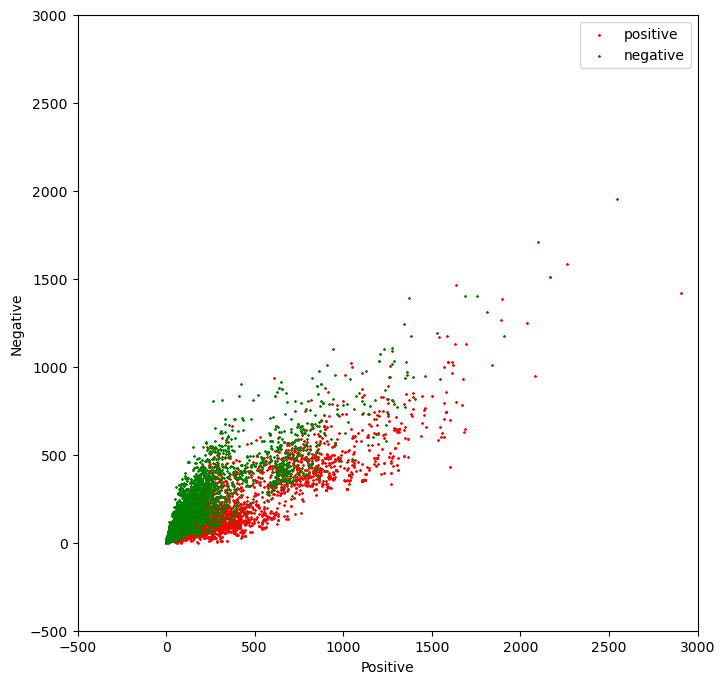

In [22]:
fig, ax= plt.subplots(figsize = (8, 8))
colors = ['green','red'] # Define a color palete
sentiments = ['negative','positive'] 

plt.xlim(-500,3000)  
plt.ylim(-500,3000)

index = eda_prep.index

for sentiment in eda_prep.target.unique():
    ix = index[eda_prep.target == sentiment]
    ax.scatter(x=eda_prep.iloc[ix].pos, y=eda_prep.iloc[ix].neg, c=colors[int(sentiment)], s=1, marker='*', label=sentiments[int(sentiment)])

ax.legend(loc='best')  

plt.xlabel("Positive") # x-axis label
plt.ylabel("Negative") # y-axis label

eda_pos = eda_prep[eda_prep.target == 1]
eda_neg = eda_prep[eda_prep.target == 0]

plt.show()

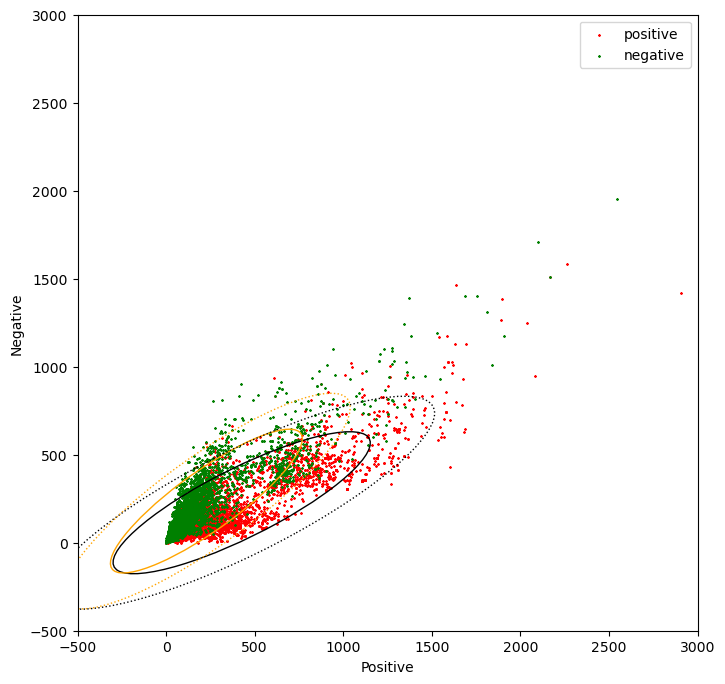

In [23]:
fig, ax= plt.subplots(figsize = (8, 8))
colors = ['green','red'] # Define a color palete
sentiments = ['negative','positive'] 

plt.xlim(-500,3000)  
plt.ylim(-500,3000)

index = eda_prep.index

for sentiment in eda_prep.target.unique():
    ix = index[eda_prep.target == sentiment]
    ax.scatter(x=eda_prep.iloc[ix].pos, y=eda_prep.iloc[ix].neg, c=colors[int(sentiment)], s=1, marker='*', label=sentiments[int(sentiment)])

ax.legend(loc='best')  

plt.xlabel("Positive") # x-axis label
plt.ylabel("Negative") # y-axis label

eda_pos = eda_prep[eda_prep.target == 1]
eda_neg = eda_prep[eda_prep.target == 0]

confidence_ellipse(eda_pos.pos, eda_pos.neg, ax, n_std=2, edgecolor='black', label=r'$2\sigma$' )
confidence_ellipse(eda_neg.pos, eda_neg.neg, ax, n_std=2, edgecolor='orange')

confidence_ellipse(eda_pos.pos, eda_pos.neg, ax, n_std=3, edgecolor='black', linestyle=':', label=r'$3\sigma$')
confidence_ellipse(eda_neg.pos, eda_neg.neg, ax, n_std=3, edgecolor='orange', linestyle=':')

plt.show()

From the chart we know that the 2 classes are a bit overlapping

# Training the model

In [24]:
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-08,11000)

In [25]:
# Test the model, comment those as they are not needed

# for tweet in ['there is a fire', 'there is sandstorm', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
#    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))    

# my_tweet = 'alert, there is earthquake'
# predict_tweet(my_tweet, freqs, theta)

In [26]:
# Below code is to examine the prediction tweet by tweet, comment those as these are not needed

# print('Label Predicted Tweet')
# for x,y in zip(train_x,labels):
#    y_hat = predict_tweet(x, freqs, theta)

#    if np.abs(y - (y_hat > 0.5)) > 0:
#        print('THE TWEET IS:', x)
#        print('THE PROCESSED TWEET IS:', process_tweet(x))
#        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

In [45]:
# Use below code to test the model

my_tweet = 'Something is happening. I can see the flame from that building!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Potential disaster')
else: 
    print('Maybe not a disaster')

['someth', 'happen', 'see', 'flame', 'build']
[[0.5046208]]
Potential disaster


# Making Prediction based on test data

In [46]:
y_hat_list = []
for x in validation['text']:
    # print(x)
    # x_process = process_tweet(x)
    # print(x_process)
    y_hat = predict_tweet(x, freqs, theta)
    y_hat_list.append(int(y_hat > 0.5))

In [47]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = pd.DataFrame({'target':y_hat_list})
sample_submission.to_csv("submission.csv", index=False)

<Axes: >

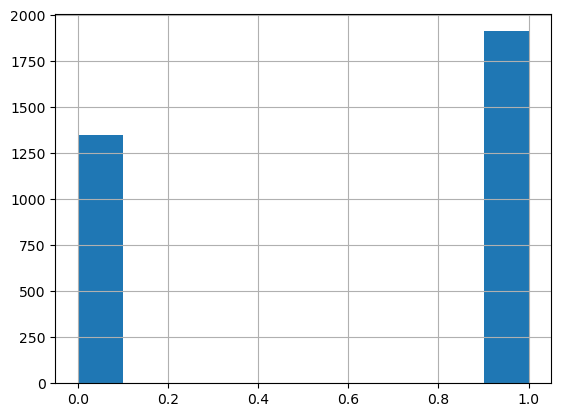

In [48]:
sample_submission.target.hist()